In [1]:
from selenium import webdriver as wd
import urllib

In [2]:
driver = wd.Chrome('../tool/chromedriver_75.0.3770.140.exe')

In [3]:
target_url = 'http://www.opinet.co.kr/searRgSelect.do'

In [4]:
# 해당사이트가 중간 페이지를 직접 접속하는 부분을 거부하기 때문에 시간차를 두고 2회 요청을 진행했다.

import time
for n in range(2):
    driver.get( target_url )
    time.sleep(5)


- 1. 시도 정보를 추출하여 리스트화 
- 2. 리스트를 반복하면서 해당 시도 밑에 시군구 리스트화
- 3. 시군구 리스트를 반복하면서 읍면동 리스트화 
- 4. 읍면동 리스트를 반복하면서 -> 조회 -> 다운로드 순으로 진행하는 것이 기본
- 5. 사이트 관찰 결과, 시도, 시군구, 읍면동 정보가 새로 세팅되면 화면의 DOM이 모두 새로 구성이 되는 문제가 있어서 반복문 안에서는
     반드시 시도, 시군구, 읍면동을 새로 잡아줘야 한다.(매우중요!!!!)
- 6. 시군구를 반복하면서 바로 조회 및 다운로드로 전개하겠다.(여기서는)

In [5]:
# 시도 리스트 획득
sidos = [ option.get_attribute('value') 
          for option in driver.find_elements_by_css_selector('#SIDO_NM0 > option') 
          if option.get_attribute('value') 
        ]
# 데이터의 상위값, 하위값 조사를 통해 샘플링 확인
sidos[1:2]

['부산광역시']

In [6]:
# 2. 시도 리스트를 반복하면서 해당 시도 밑에 시군구 리스트화
# sidos 중에 부산만 대상으로 수집. (밑에)
for sido in sidos[1:2]:
    # 2-1. sido 대상을 찾아 
    sido_tag = driver.find_element_by_id('SIDO_NM0')
    
    # 2-2. 시도값을 설정
    sido_tag.send_keys( sido )
        # 2-2-2. 잠시대기(ajax 통신 후 화면이 재구성 될 때까지)
    time.sleep(6)
    
    # 2-3. 시군구 리스트를 획득
    sigungus = [ option.get_attribute('value') 
        for option in driver.find_elements_by_css_selector('#SIGUNGU_NM0 > option') 
        if option.get_attribute('value') 
    ]
    print( sido, sigungus[:2] )
    
    # 2-4. 반복~ 3단계로 진입
    # 3. 시군구 리스트를 반복하면서 -> 잠시대기(5초) -> 엑셀 저장
    for sigungu in sigungus:
        # 3-1. 시군구 태그를 찾아서
        sigungu_tag = driver.find_element_by_id('SIGUNGU_NM0')
        # 3-2. 시군구값 설정
        sigungu_tag.send_keys( sigungu )
        # 3-3. 잠시 대기
        time.sleep(5)
        # 3-4. 엑셀 저장
        driver.find_element_by_id('glopopd_excel').click()

부산광역시 ['강서구', '금정구']


In [7]:
# 2. 시도 리스트를 반복하면서 해당 시도 밑에 시군구 리스트화
# sidos 중에 부산만 대상으로 수집하겟다
for sido in sidos[1:2]:
    # 2-1. sido 대상 찾아서
    sido_tag = driver.find_element_by_id('SIDO_NM0')
    # 2-2. sido 값을 설정
    sido_tag.send_keys( sido )
    # 2-2-2. 잠시대기(ajax 통신후 화면이 재구성될대까지)
    time.sleep(6)
    # 2-3. 시군구 리스트 획득
    sigungos = [ option.get_attribute('value') 
        for option in driver.find_elements_by_css_selector('#SIGUNGU_NM0 > option') 
        if option.get_attribute('value') 
    ]
    print( sido, sigungos[:2] )
    # 2-4. 반복~ 3단계로 진입
    # 3. 시군구 리스트를 반복하면서 ->  잠시대기(5초대기) -> 엑셀저장
    for sigungo in sigungos:
        # 3-1. 시군구 태그를 찾아서
        sigungo_tag = driver.find_element_by_id('SIGUNGU_NM0')
        # 3-2. 시군구값 설정
        sigungo_tag.send_keys( sigungo )
        # 3-3. 잠시 대기
        time.sleep(5)
        # 3-4. 엑셀 저장
        driver.find_element_by_id('glopopd_excel').click()

부산광역시 ['강서구', '금정구']


KeyboardInterrupt: 

### 데이터 수집 완료

- 수십 개의 엑셀 파일을 반복적으로 읽어서 DataFrame으로 구성하기

In [38]:
# glob 특정 위치상에 존재하는 파일들을 패턴을 지정하여 목록을 구성할 수 있다.
from glob import glob
import pandas as pd

In [48]:
# 부산관한 시군구에 조회된 엑셀 자료를 읽을 수 있게 파일 경로를 리스트화
down_files = glob('C:/Users/User/Downloads/지역*.xls')
down_files[:2],down_files[-2:]

(['C:/Users/User/Downloads\\지역_위치별(주유소) (1).xls',
  'C:/Users/User/Downloads\\지역_위치별(주유소) (10).xls'],
 ['C:/Users/User/Downloads\\지역_위치별(주유소) (9).xls',
  'C:/Users/User/Downloads\\지역_위치별(주유소).xls'])

In [49]:
# 그냥 참고만(아직 배우기전)
# conda install xlrd
tmp_raws = []
for file in down_files:
    tmp = pd.read_excel( file, header=2 )
    tmp_raws.append( tmp )
# 여기는 데이터 확인차!! 
st_raw = pd.concat( tmp_raws )

In [50]:
st_raw.shape

(422, 10)

In [177]:
st_raw

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
0,부산광역시,청룡명품주유소,부산 금정구 중앙대로2130,현대오일뱅크,051-508-5150,N,-,1442,1292,-
1,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1443,1293,-
2,부산광역시,은마석유 노포주유소,부산 금정구 중앙대로 2191 (노포동),GS칼텍스,051-508-1645,Y,-,1443,1293,1050
3,부산광역시,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,051-582-5882,N,-,1443,1293,-
4,부산광역시,광신석유(주)직영경부고속주유소,부산 금정구 중앙대로1720번길 7 (부곡동),SK에너지,051-517-6011,Y,-,1455,1315,1010
5,부산광역시,지에스칼텍스(주)신창주유소,부산 금정구 중앙대로 1698 (부곡동),GS칼텍스,051-581-1212,N,1730,1455,1315,990
6,부산광역시,A1 주유소,부산 금정구 반송로 364 (서동),현대오일뱅크,051-532-5157,Y,-,1458,1297,-
7,부산광역시,거북이주유소(SK),부산 금정구 중앙대로 1672 (부곡동),SK에너지,051-516-5151,Y,-,1463,1323,-
8,부산광역시,현대오일뱅크㈜ 직영 금정셀프주유소,부산 금정구 중앙대로 1664 (부곡동),현대오일뱅크,051-583-8951,Y,-,1463,1323,-
9,부산광역시,동진주유소,"부산 금정구 금정로 216, (구서동)",SK에너지,051-515-5007,Y,1623,1463,1323,1100


- 응용 : 시군구 단우> 읍면동 단위
> 1. 주유소정보데이터 부산시 행정구역으로 표현  
> 2. 자치구별 가장 저렴한 주유소 마킹  
> 3. 행정구역별 주유가격 평균을 통해서 칼라맵으로 표시, 휘발유기준, 가격없는 주유소는 배제  
> 4. 브랜드별(6개) 알뜰주유소 VS 브랜드대비, 진짜 싼지 체크  
     -> seaborn의 박스플롯과 스완플롯을 같이 활용하여 시각화 한다.  
     -> 브랜드,셀프여부, 경유/휘발유 등등

In [53]:
import folium

In [81]:
tmp = st_raw[ st_raw['주소'].apply( lambda x: x.find('동)')<0)]
tmp

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
0,부산광역시,청룡명품주유소,부산 금정구 중앙대로2130,현대오일뱅크,051-508-5150,N,-,1442,1292,-
1,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1443,1293,-
13,부산광역시,신화주유소,부산 금정구 금강로 721,현대오일뱅크,051-515-1997,Y,-,1468,1328,1100
23,부산광역시,국제,부산 금정구 중앙대로 1756,SK에너지,051-516-8516,N,1935,1665,1535,-
0,부산광역시,(주)디시에너지,부산 서구 보수대로 220,현대오일뱅크,051-243-0444,Y,-,1438,1288,1050
3,부산광역시,(주)디시에너지 대신지점,부산 서구 대영로 91,현대오일뱅크,051-242-8144,Y,-,1448,1298,-
6,부산광역시,(주)우양네트웍스 고려주유소,부산 서구 대영로 88 (동대신동1가),S-OIL,051-973-7555,N,-,1468,1328,1100
10,부산광역시,(주)부영에너지직영신일주유소,부산 서구 구덕로 273 (서대신동1가),SK에너지,051-256-3929,Y,-,1488,1358,1050
11,부산광역시,보배주유소,부산 서구 대신공원로 1 (동대신동3가),SK에너지,051-254-6077,N,-,1548,1448,1100
2,부산광역시,㈜천일에너지 천일주유소,부산 수영구 광남로 83,현대오일뱅크,051-754-5182,Y,-,1438,1298,-


In [107]:
st_raw['휘발유'].unique()

array([1442, 1443, 1455, 1458, 1463, 1465, 1468, 1469, 1483, 1488, 1497,
       1498, 1519, 1535, 1539, 1577, 1665, 1438, 1440, 1448, 1478, 1548,
       1437, 1477, 1485, 1495, 1547, 1620, 1638, 1648, 1453, 1479, 1482,
       1518, 1598, 1628, 1644, 1398, 1565, 1427, 1434, 1435, 1445, 1475,
       1505, 1523, 1553, 1563, 1613, 1459, 1487, 1490, 1494, 1545, 1649,
       1419, 1420, 1424, 1447, 1457, 1467, 1489, 1508, 1538, 1569, 1585,
       1446, 1845, 1499, 1699, 1425, 1428, 1429, 1471, 1528, 1575, 1433,
       1509, 1544, 1414, 1415, 1418, 1464, 1579, 1597, 1599, 1729, '1430',
       '1447', '1448', '1452', '1458', '1468', '1478', '1487', '1488',
       '1489', '1495', '1497', '1498', '1508', '1518', '1563', '-', 1529],
      dtype=object)

In [112]:
# 지도 시각화의 기준점이 휘발유 가격이므로 , 휘발유 가겨을 정제하여
# 의미있는 데이터만 남긴다.
st_raw_price_exist = st_raw[ st_raw['휘발유'] != '-' ]
st_raw_price_exist.shape

(419, 10)

In [115]:
st_raw_price_exist.dtypes

지역       object
상호       object
주소       object
상표       object
전화번호     object
셀프여부     object
고급휘발유    object
휘발유      object
경유       object
실내등유     object
dtype: object

In [131]:
st_raw_price_exist['휘발유'] = st_raw_price_exist['휘발유'].astype(int)

C:\Users\User\Anaconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [124]:
st_raw_price_exist['휘발유'].unique()

array([1442, 1443, 1455, 1458, 1463, 1465, 1468, 1469, 1483, 1488, 1497,
       1498, 1519, 1535, 1539, 1577, 1665, 1438, 1440, 1448, 1478, 1548,
       1437, 1477, 1485, 1495, 1547, 1620, 1638, 1648, 1453, 1479, 1482,
       1518, 1598, 1628, 1644, 1398, 1565, 1427, 1434, 1435, 1445, 1475,
       1505, 1523, 1553, 1563, 1613, 1459, 1487, 1490, 1494, 1545, 1649,
       1419, 1420, 1424, 1447, 1457, 1467, 1489, 1508, 1538, 1569, 1585,
       1446, 1845, 1499, 1699, 1425, 1428, 1429, 1471, 1528, 1575, 1433,
       1509, 1544, 1414, 1415, 1418, 1464, 1579, 1597, 1599, 1729, 1430,
       1452, 1529], dtype=int64)

In [125]:
st_raw_price_exist['휘발유'].dtypes

dtype('int32')

In [145]:
# 위에까지 준비 단계

# > 1. 주유소정보데이터 부산시 행정구역으로 표현  

In [149]:
tmp_gu = st_raw_price_exist['주소'].apply( lambda x: x.split()[1])
st_raw_price_exist['자치구'] = tmp_gu

C:\Users\User\Anaconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [153]:
# 부산의 총 자치구 중복성 검사. 16개 확인
st_raw_price_exist['자치구'].unique()

array(['금정구', '서구', '수영구', '연제구', '영도구', '중구', '해운대구', '기장군', '남구', '동구',
       '동래구', '부산진구', '북구', '사상구', '사하구', '강서구'], dtype=object)

In [154]:
# 자치구간 평균 값이 입력됨.(pivot 자체)
pd.pivot_table( st_raw_price_exist, index='자치구' )


,휘발유
자치구,
강서구,1476.612245
금정구,1485.708333
기장군,1461.217391
남구,1483.800000
동구,1497.100000
동래구,1472.250000
부산진구,1476.166667
북구,1464.842105
사상구,1470.696429


In [159]:
st_raw_gasoline = pd.pivot_table( st_raw_price_exist, index='자치구' )
st_raw_gasoline.sort_values(by='휘발유')
# 여기까지가 지도에 넣을 데이터부분 완료

,휘발유
자치구,
기장군,1461.217391
북구,1464.842105
연제구,1464.882353
서구,1468.166667
사상구,1470.696429
동래구,1472.250000
사하구,1473.000000
부산진구,1476.166667
강서구,1476.612245


In [160]:
# min, max sclaer를 이용한 정규화를 통해서 가격비율 컴럼을 생성
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [161]:
x        = st_raw_gasoline.values 
x_scaled = min_max_scaler.fit_transform(x.astype(float))
x_scaled

array([[0.21571709],
       [0.34317409],
       [0.        ],
       [0.31643397],
       [0.50279738],
       [0.15459207],
       [0.20947352],
       [0.05079053],
       [0.13282298],
       [0.16510128],
       [0.09737523],
       [0.5211782 ],
       [0.05135449],
       [1.        ],
       [0.28420572],
       [0.25348647]])

In [162]:
tmp = pd.DataFrame(x_scaled, columns=['휘발유정규화'], index=st_raw_gasoline.index)
tmp.head(2)

,휘발유정규화
자치구,
강서구,0.215717
금정구,0.343174


In [201]:
st_raw_price_exist['휘발유'].mean()

1476.692124105012

In [203]:
import folium
import json
geo_str = json.load( open( '../pandas/data/busan.json', encoding='utf-8'))
geo_str

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'id': '기장군',
   'properties': {'code': '21310',
    'name': '기장군',
    'name_eng': 'Gijang-gun',
    'base_year': '2013'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[129.2052495079534, 35.384810829415144],
      [129.21999816556436, 35.37561304214919],
      [129.26755198854022, 35.38341226661066],
      [129.2857909875702, 35.35965182306521],
      [129.2821380596251, 35.33844963971255],
      [129.30681468573164, 35.32644771030098],
      [129.2675569665142, 35.31604143854397],
      [129.26275266580004, 35.27831941566859],
      [129.24546065083584, 35.26120427164311],
      [129.25565431808167, 35.243593230216504],
      [129.23550974472084, 35.21139611410482],
      [129.22731336081907, 35.1832196018314],
      [129.2101963573097, 35.178863012450506],
      [129.20926574987496, 35.193858050365115],
      [129.1712609088194, 35.19779178977021],
      [129.15946955367855, 35.2060010318845],
      [129.1

In [223]:
gps = [ 35.1684034,129.0348365 ] 
zoom = 11
map_busan = folium.Map( location=gps, zoom_start=zoom)
# 마커
folium.Choropleth( geo_data=geo_str
                   ,name='busan'
                   ,data=tmp 
                   ,columns=[ tmp.index, '휘발유정규화' ]
                   ,key_on='feature.id'
                   ,fill_color='PuRd'
                   ,legend_name='부산시 자치구별 휘발유가격 비율'
                 ).add_to(map_busan)
map_busan

###  4.브랜드별(6개) 알뜰주유소 VS 브랜드대비, 진짜 싼지 체크 
     -> seaborn의 박스플롯과 스완플롯을 같이 활용하여 시각화 한다.  
     -> 브랜드,셀프여부, 경유/휘발유 등등

In [220]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [265]:
from korean_font import initKoreaFontLoad
initKoreaFontLoad()

#실행 안될 시 해당 폴더에  'korean_font.ipynb' , 'korean_font.py' 파일 있는지 확인하기

Malgun Gothic


In [258]:
# 씨본로드
import seaborn as sns

In [259]:
# 뒷배경
sns.set_style('whitegrid')

In [260]:
st_raw_price_exist.head(2)

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
0,부산광역시,청룡명품주유소,부산 금정구 중앙대로2130,현대오일뱅크,051-508-5150,N,-,1442,1292,-,금정구
1,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1443,1293,-,금정구


<function matplotlib.pyplot.show(*args, **kw)>

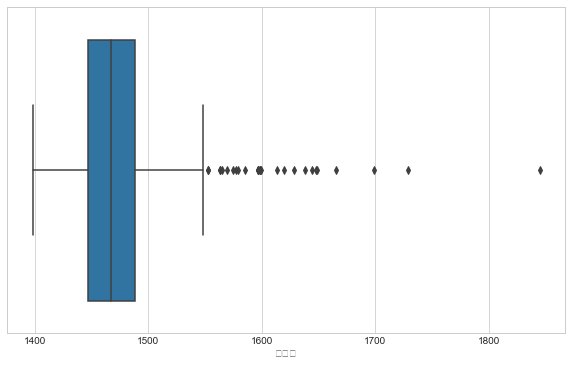

In [261]:
plt.figure(figsize=(10,6))
sns.boxplot( x=st_raw_price_exist['휘발유'])
plt.show

In [262]:
st_raw_price_exist.columns

Index(['지역', '상호', '주소', '상표', '전화번호', '셀프여부', '고급휘발유', '휘발유', '경유', '실내등유',
       '자치구'],
      dtype='object')

In [263]:
st_raw_price_exist['상표'].unique()

array(['현대오일뱅크', 'SK에너지', 'GS칼텍스', '알뜰주유소', 'S-OIL', '자가상표', 'NH-OIL'],
      dtype=object)

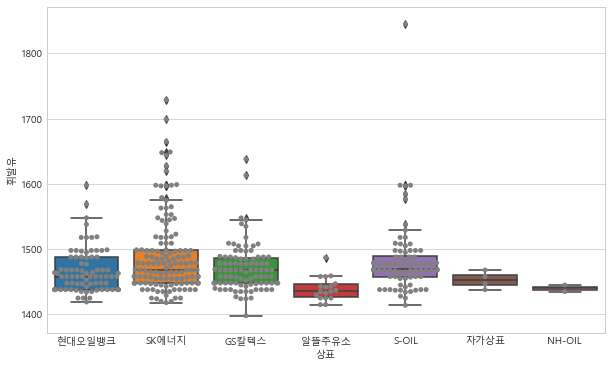

In [266]:
plt.figure(figsize=(10,6))
sns.boxplot( x='상표',y='휘발유', data=st_raw_price_exist)
sns.swarmplot( x='상표',y='휘발유', data=st_raw_price_exist,color='0.5' )
plt.show()

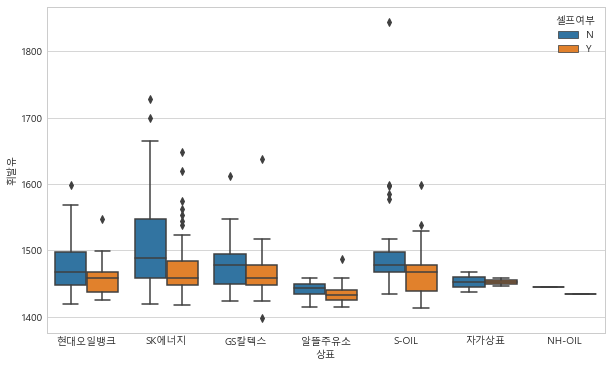

In [267]:
plt.figure(figsize=(10,6))
sns.boxplot( x='상표',y='휘발유', data=st_raw_price_exist, hue='셀프여부')
plt.show()

In [274]:
plt.figure(figsize=(10,6))
sns.boxplot( x='상표', y= '')
plt.show()

SyntaxError: invalid syntax (<ipython-input-274-beb880c1924e>, line 2)